# 3D medical image segmentation with one slice annotation

This notebook shows how to use SAM 2 for interactive segmentation in 3D images. It will cover the following:

- propagating a mask to get _masklets_ throughout the video

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [3]:
import os
 
new_dir = "/scratch/mtc5693/SAM_2_Medical_3D"

os.chdir(new_dir)

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

len of frames:  127


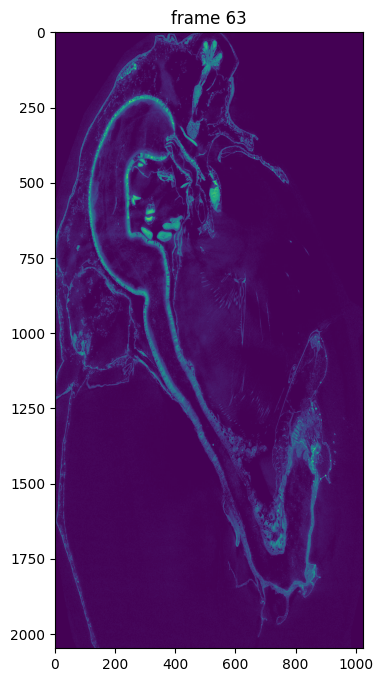

In [8]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./notebooks/videos/our_data/aaa392_bin0_down" 
ann_obj_id = 1
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
print("len of frames: ", len(frame_names))
# take a look the first video frame
frame_idx = len(frame_names) // 2
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

load one mask

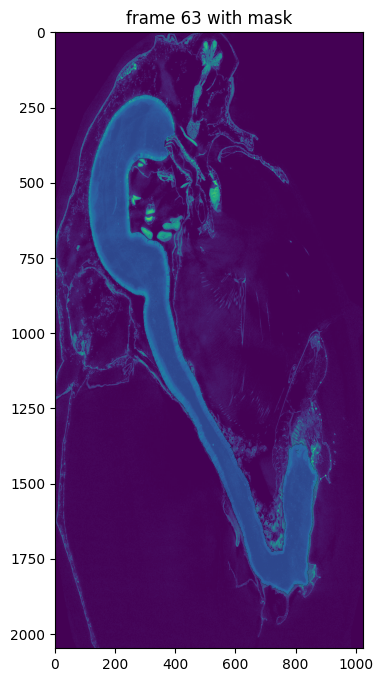

In [14]:
out_mask_logits = np.load(os.path.join(video_dir, frame_names[frame_idx].replace(".jpg", ".npy")))
out_mask_logits = out_mask_logits.T

plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx} with mask")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
show_mask(out_mask_logits, plt.gca())

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).
#### Propagate the prompts to get the masklet across the video

In [15]:
# run propagation to get the mask for the entire video
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)
predictor.add_new_mask(inference_state=inference_state, frame_idx=frame_idx, obj_id=ann_obj_id, mask=out_mask_logits > 0.0)

frame loading (JPEG):   0%|          | 0/127 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 127/127 [00:05<00:00, 23.43it/s]


(63,
 [1],
 tensor([[[[-10.0000, -10.0000, -10.0000,  ..., -10.0000, -10.0000, -10.0000],
           [-10.0000, -10.0000, -10.0000,  ..., -10.0000, -10.0000, -10.0000],
           [-10.0000, -10.0000, -10.0000,  ..., -10.0000, -10.0000, -10.0000],
           ...,
           [-10.0000, -10.0000, -10.0000,  ..., -10.0000, -10.0000, -10.0000],
           [-10.0000, -10.0000, -10.0000,  ..., -10.0000, -10.0000, -10.0000],
           [-10.0000, -10.0000, -10.0000,  ..., -10.0000, -10.0000, -10.0000]]]],
        device='cuda:0'))

In [16]:
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video:  83%|████████▎ | 53/64 [00:03<00:00, 23.18it/s]

propagate in video: 100%|██████████| 64/64 [00:03<00:00, 17.56it/s]


In [17]:
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=frame_idx-1, reverse=True):
    
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video:  76%|███████▌  | 48/63 [00:02<00:00, 23.89it/s]

propagate in video: 100%|██████████| 63/63 [00:02<00:00, 23.88it/s]


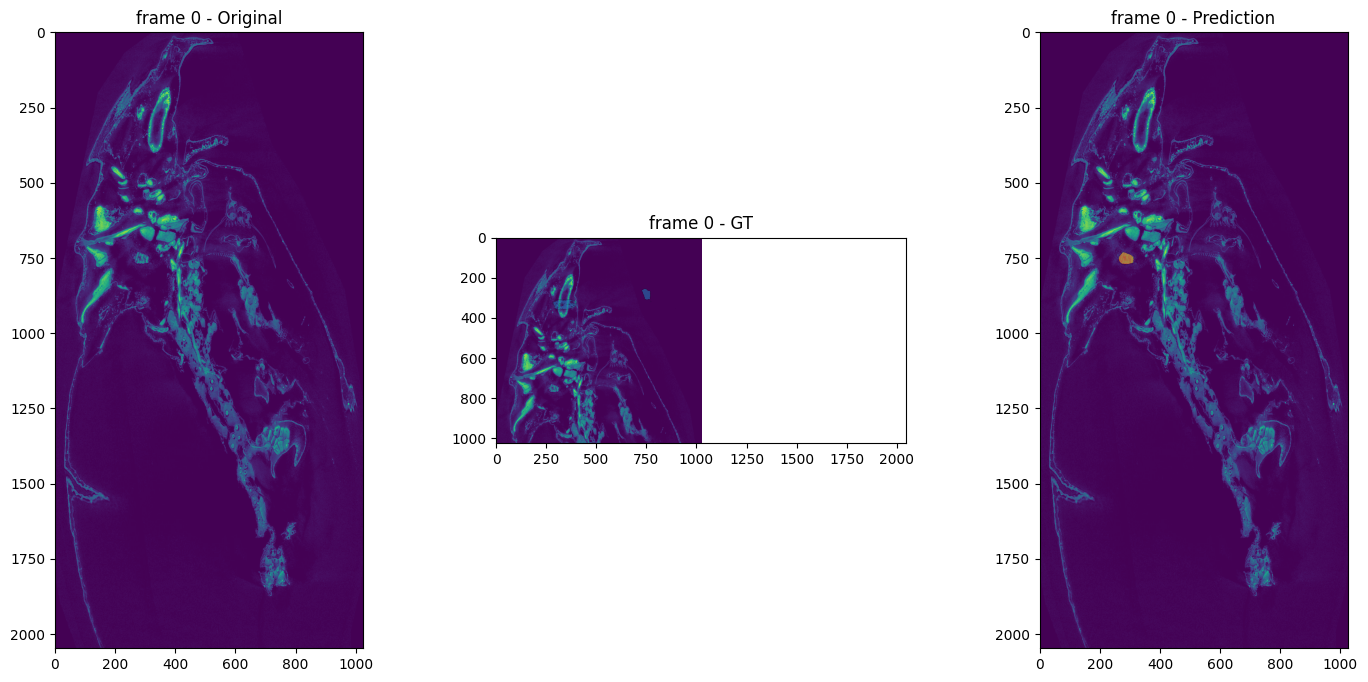

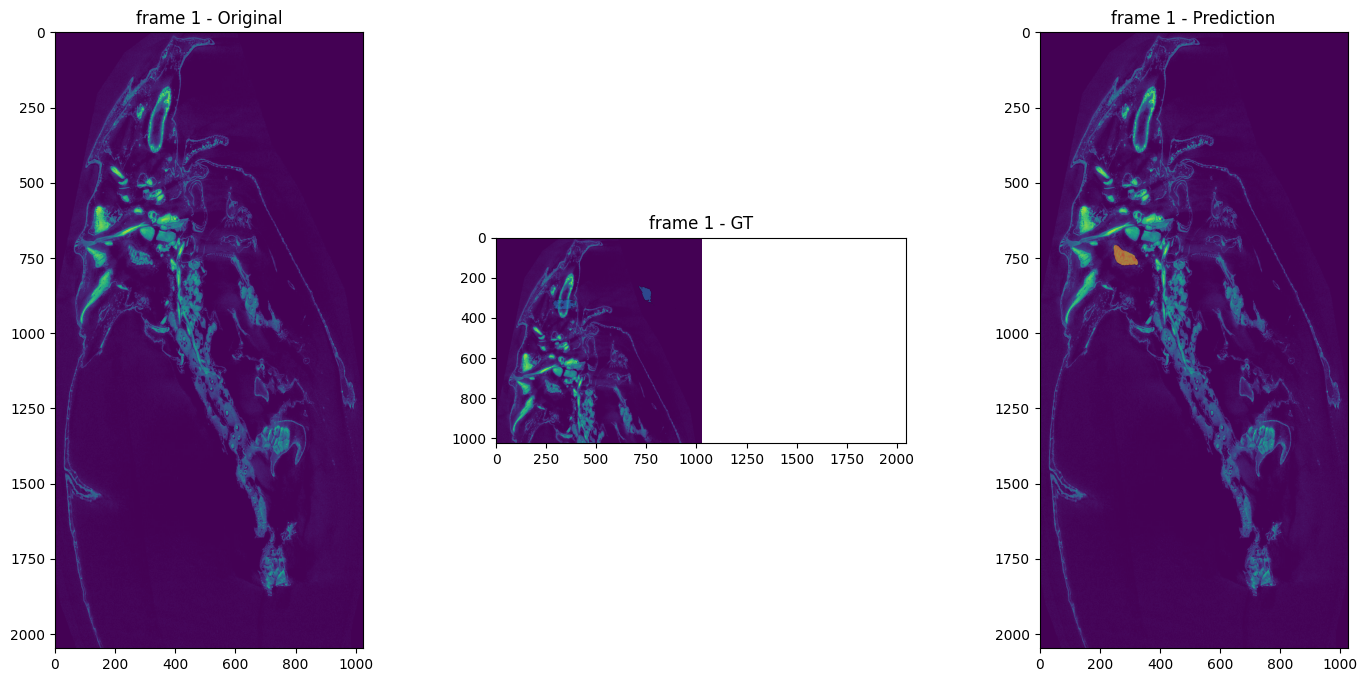

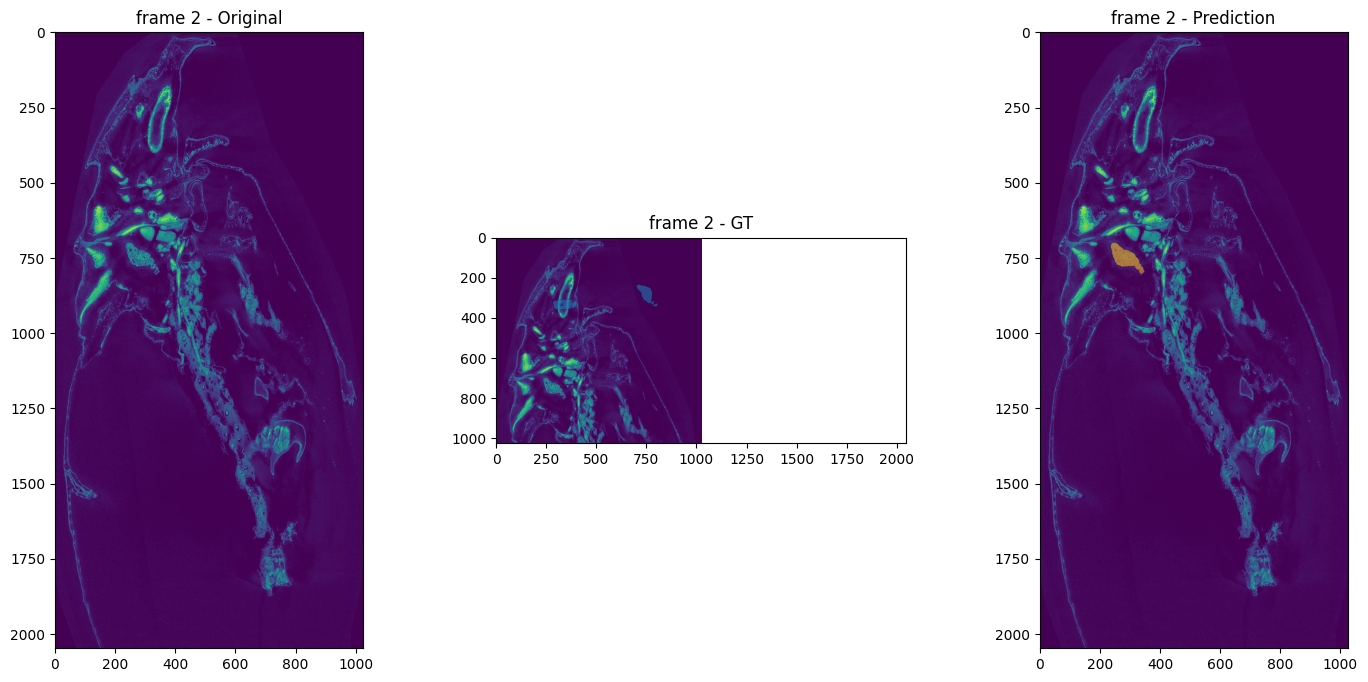

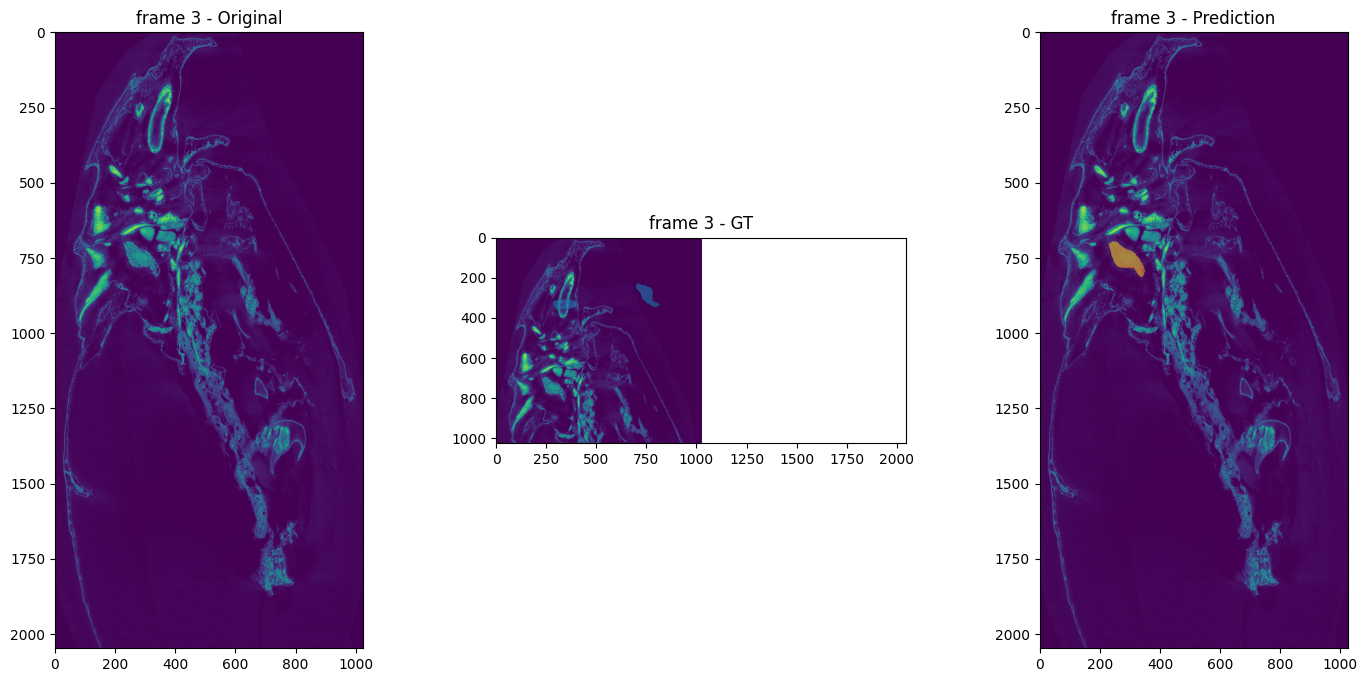

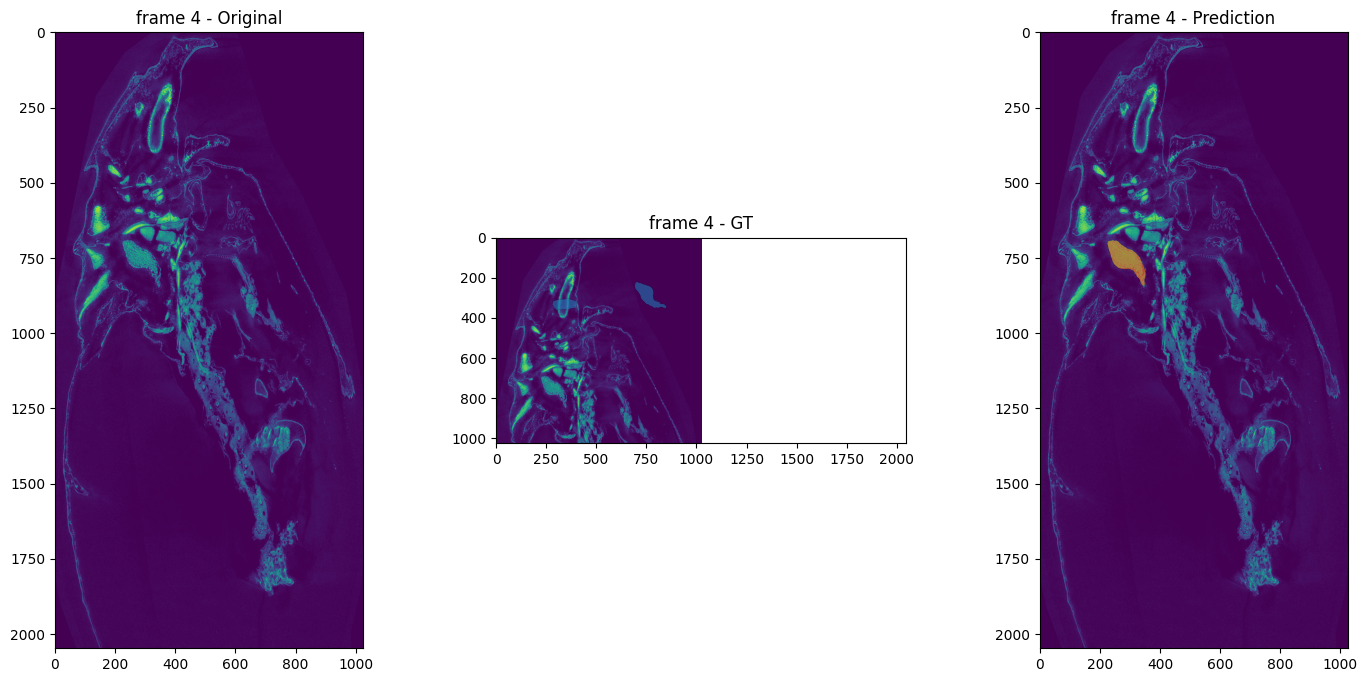

In [ ]:
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))  
    # 原图 subplot
    axes[0].set_title(f"frame {out_frame_idx} - Original")
    original_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[0].imshow(original_image)
    
    # Ground truth subplot
    axes[1].set_title(f"frame {out_frame_idx} - GT")
    gt_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[1].imshow(gt_image)
    out_mask_logits_gt = np.load(os.path.join(video_dir, frame_names[out_frame_idx].replace(".jpg", ".npy")))
    show_mask(out_mask_logits_gt, axes[1])
    
    # Predicted result subplot
    axes[2].set_title(f"frame {out_frame_idx} - Prediction")
    pred_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[2].imshow(pred_image)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, axes[2], obj_id=out_obj_id)
    
    plt.show()


In [ ]:
video_seg_3d = np.stack([video_segments[k][1] for k in video_segments])
gt_3d = np.stack([np.load(os.path.join(video_dir, frame_names[k].replace(".jpg", ".npy")))[None] for k in video_segments])

In [ ]:
import torch
from monai.metrics import DiceHelper, compute_surface_dice

n_classes, batch_size = 1, 1
spatial_shape = (video_seg_3d.shape[0], video_seg_3d.shape[2], video_seg_3d.shape[3]) 

y_pred = torch.tensor(video_seg_3d).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
y = torch.tensor(gt_3d).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth

score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
print('dice score:', score)

print('nsd score:', compute_surface_dice(y_pred, y, class_thresholds=[1]))

dice score: tensor([0.8926])
nsd score: tensor([[0.6862]])
